In [1]:
%cd ..

/home/david/Desktop/NMEC-Using-DL


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from models.fnn import FNN
from datasets.Hourly import HourlyLoader
from torch.utils.data import DataLoader
from main import *

## Training Baseline FNN

In [3]:
train = pd.read_csv('program_baseline/train-test/train.csv')
test = pd.read_csv('program_baseline/train-test/test.csv')

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_loader = DataLoader(HourlyLoader(train.iloc[:, 1:]), batch_size=128, shuffle=True)
test_loader = DataLoader(HourlyLoader(test.iloc[:, 1:]), batch_size=128, shuffle=True)
model = FNN(8, 1, [128, 64, 32, 16], nn.LeakyReLU(0.02), batch_norm=True).to(device)
lr = 5e-5
optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = nn.MSELoss()
num_epochs = 100
train_loss, test_loss = train_and_evaluate(model, optimizer, criterion,
                                           train_loader, test_loader,
                                           num_epochs, device)

Epoch 1 - Train Loss: 0.8470, Test Loss: 0.7766
Epoch 2 - Train Loss: 0.6113, Test Loss: 0.6113
Epoch 3 - Train Loss: 0.5310, Test Loss: 0.5404
Epoch 4 - Train Loss: 0.4868, Test Loss: 0.5083
Epoch 5 - Train Loss: 0.4631, Test Loss: 0.4838
Epoch 6 - Train Loss: 0.4452, Test Loss: 0.4725
Epoch 7 - Train Loss: 0.4289, Test Loss: 0.4662
Epoch 8 - Train Loss: 0.4182, Test Loss: 0.4420
Epoch 9 - Train Loss: 0.4094, Test Loss: 0.4369
Epoch 10 - Train Loss: 0.3998, Test Loss: 0.4282
Epoch 11 - Train Loss: 0.3918, Test Loss: 0.4197
Epoch 12 - Train Loss: 0.3854, Test Loss: 0.4127
Epoch 13 - Train Loss: 0.3795, Test Loss: 0.4053
Epoch 14 - Train Loss: 0.3732, Test Loss: 0.4000
Epoch 15 - Train Loss: 0.3689, Test Loss: 0.4025
Epoch 16 - Train Loss: 0.3657, Test Loss: 0.3917
Epoch 17 - Train Loss: 0.3621, Test Loss: 0.3845
Epoch 18 - Train Loss: 0.3573, Test Loss: 0.3840
Epoch 19 - Train Loss: 0.3526, Test Loss: 0.3876
Epoch 20 - Train Loss: 0.3499, Test Loss: 0.3795
Epoch 21 - Train Loss: 0.3440

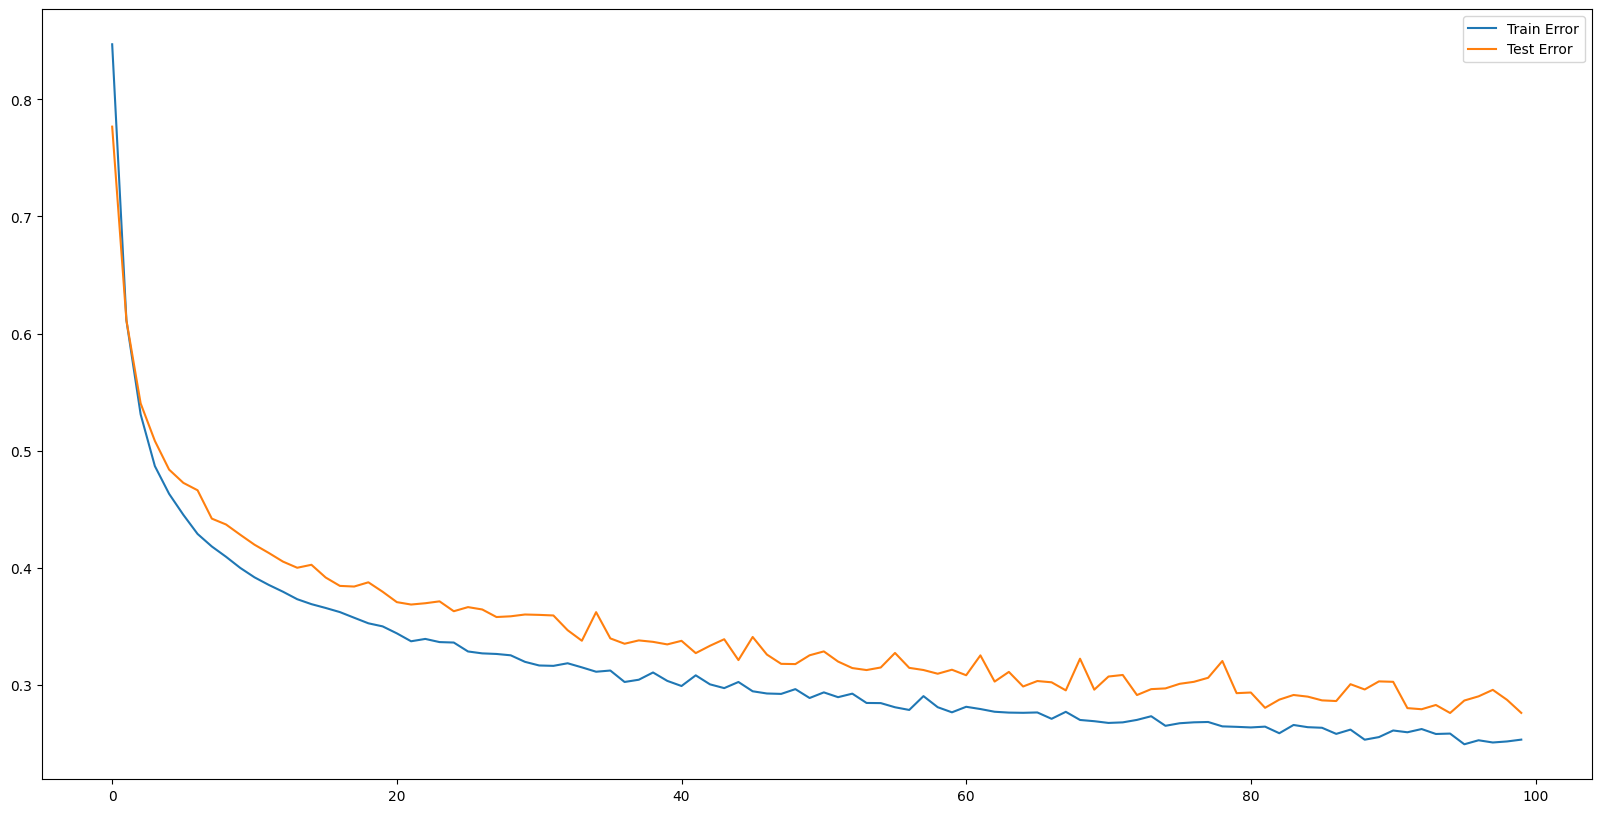

In [14]:
plt.figure(figsize=(20,10))
plt.plot(train_loss, label = 'Train Error')
plt.plot(test_loss, label = 'Test Error')
plt.legend()
plt.show()

## Compare to In-Program
- Make sure to scale the total for in-program

In [19]:
import pickle
scale_path = 'weights/scalers/load_scaler.pkl'

with open(scale_path, 'rb') as file:
    scaler = pickle.load(file)

in_program = pd.read_csv('program_baseline/in_prog_mean.csv')
in_program['scaled_total'] = scaler.transform(in_program['total'].values.reshape(-1,1))

/home/david/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [27]:
model.cpu()
features = in_program.iloc[:, 1:-2]
features_tensor = torch.tensor(features.values, dtype=torch.float32)

# Ensuring the model is in evaluation mode
model.eval()

# Passing the features tensor through the model
with torch.no_grad():
    predictions = model(features_tensor)

# If you want the predictions as a numpy array
in_program['Prediction_Scaled'] = predictions.numpy()
in_program['Prediction'] = scaler.inverse_transform(in_program['Prediction_Scaled'].values.reshape(-1,1))

In [31]:
in_program['datetime'] = pd.to_datetime(in_program['datetime'])

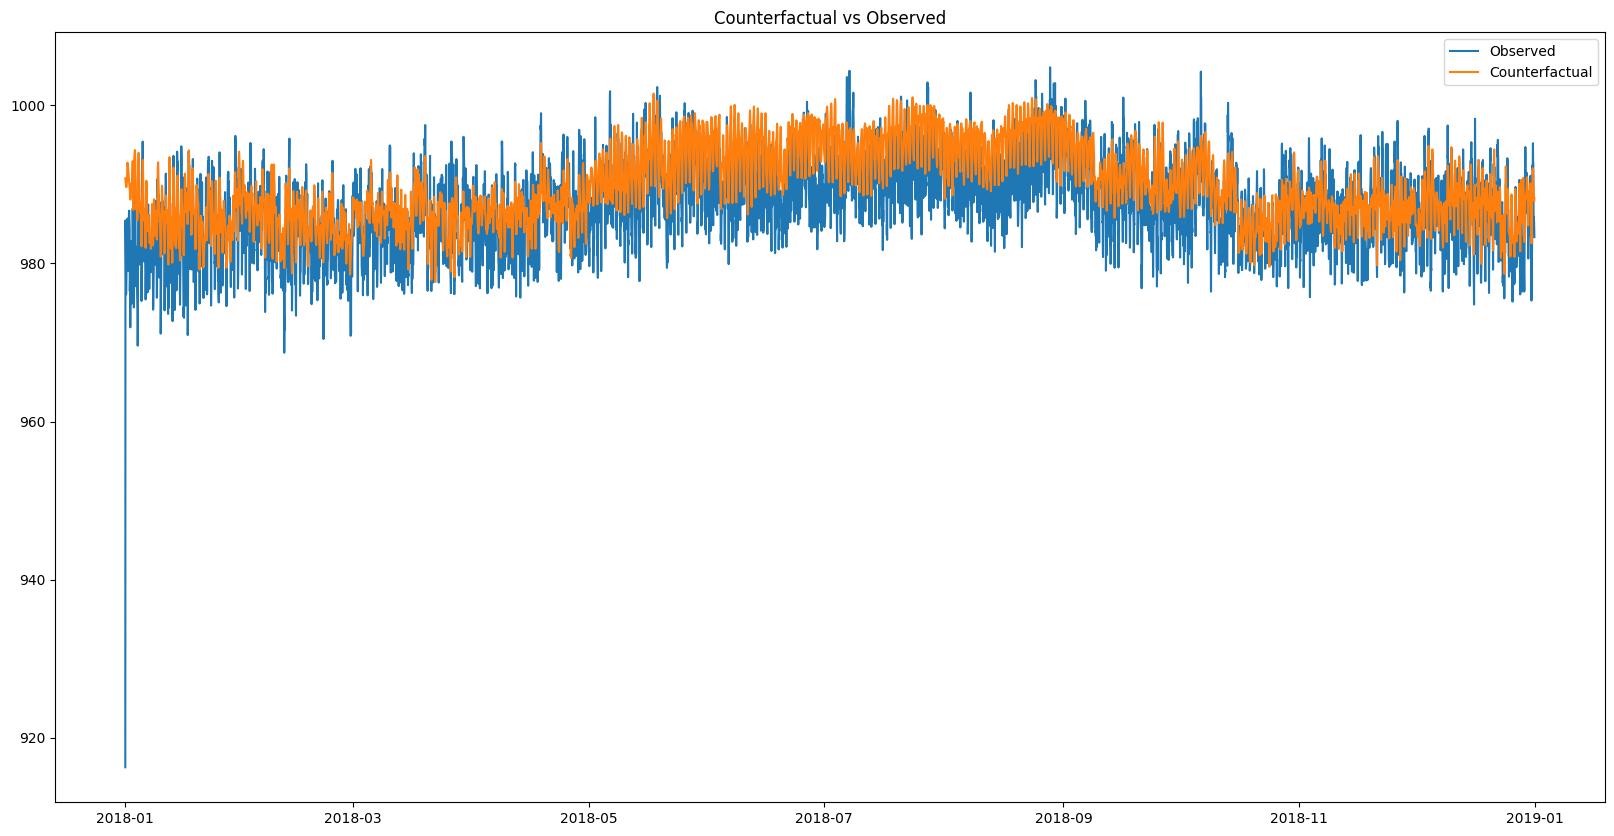

In [32]:
# Plot the NN forecast vs Observed
plt.figure(figsize=(20,10))
plt.title('Counterfactual vs Observed')
plt.plot(in_program['datetime'], in_program['total'], label = 'Observed')
plt.plot(in_program['datetime'], in_program['Prediction'], label = 'Counterfactual')
plt.legend()
plt.show()

In [33]:
in_program

,datetime,year,month,day,hour,isBday,TMIN,TAVG,TMAX,total,scaled_total,Prediction_Scaled,Prediction
0,2018-01-01 01:00:00,2018.0,1.0,1.0,1.0,1.0,-4.566667,-2.2,1.100,916.281000,-12.318792,0.098594,990.761169
1,2018-01-01 02:00:00,2018.0,1.0,1.0,2.0,1.0,-4.566667,-2.2,1.100,985.436231,-0.789187,0.039736,990.408142
2,2018-01-01 03:00:00,2018.0,1.0,1.0,3.0,1.0,-4.566667,-2.2,1.100,984.340500,-0.971868,0.029565,990.347168
3,2018-01-01 04:00:00,2018.0,1.0,1.0,4.0,1.0,-4.566667,-2.2,1.100,982.282083,-1.315048,0.021125,990.296509
4,2018-01-01 05:00:00,2018.0,1.0,1.0,5.0,1.0,-4.566667,-2.2,1.100,979.845462,-1.721284,-0.042166,989.916931
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8747,2018-12-31 19:00:00,2018.0,12.0,31.0,19.0,1.0,3.325000,8.2,14.325,985.844308,-0.721152,-0.324077,988.226013
8748,2018-12-31 20:00:00,2018.0,12.0,31.0,20.0,1.0,3.325000,8.2,14.325,985.057231,-0.852374,-0.373417,987.930054
8749,2018-12-31 21:00:00,2018.0,12.0,31.0,21.0,1.0,3.325000,8.2,14.325,985.265462,-0.817658,-0.378024,987.902405
8750,2018-12-31 22:00:00,2018.0,12.0,31.0,22.0,1.0,3.325000,8.2,14.325,984.178538,-0.998870,-0.378535,987.899353


In [34]:
from sklearn.metrics import mean_squared_error

# Assume df is your DataFrame and 'col1' and 'col2' are the columns you want to compare
mse = mean_squared_error(in_program['scaled_total'], in_program['Prediction_Scaled'])

print(f"The Mean Squared Error (MSE) between the two columns is {mse}")


The Mean Squared Error (MSE) between the two columns is 0.5155373587649372


In [37]:
(in_program['Prediction'] - in_program['total']).sum()

20572.291243327774